This notebook is just to generate saved DDPM model with mixed precision needed in lesson 21.  Based on DDPM_v3 notebook.  REQUIRES GPU

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *
from minai.sgd import *
from minai.resnet import *
from minai.augment import *
from minai.accel import *

In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

Note this uses the fixed scaling of the training images so that they scale from -.5 to .5

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
from types import SimpleNamespace

def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

def abar(t, T): return (t/T*math.pi/2).cos()**2

n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [5]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

In [6]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [7]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))


lr = 1e-2
epochs = 10 # note the course used 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/home/ron/datadev/pdl/minai/accel.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


loss,epoch,train
0.191,0,train
0.040,0,eval
0.037,1,train
0.032,1,eval
0.032,2,train
0.032,2,eval
0.028,3,train
0.028,3,eval
0.026,4,train
0.027,4,eval


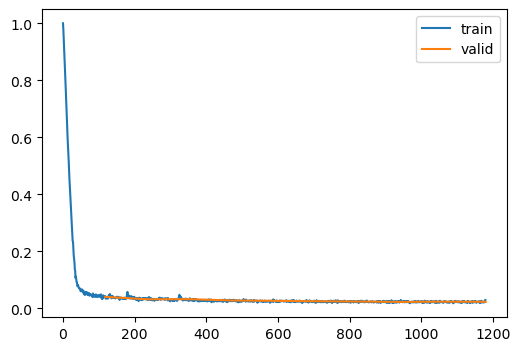

In [8]:
learn.fit(epochs)

In [9]:
mdl_path = Path('models')
#torch.save(learn.model, mdl_path/'fashion_ddpmDec15.pkl')


In [22]:
clean_mem()

In [23]:


model = torch.load(mdl_path/'fashion_ddpmDec15.pkl').cuda()

/tmp/ipykernel_60980/1238524032.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(mdl_path/'fashion_ddpmDec15.pkl').cuda()


In [24]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

n_samples = 512



In [19]:
ps = next(model.parameters())
ps.device

device(type='cuda', index=0)

For soem reason this is much slower then in Jeremys notebook.  Order of 3 minutes for just 16 images, while he did 512 in same time. I did notice my cuda dedicated memory was full and cleaning it up did speed things up to 23 seconds for 16 image, which would mean 10 minutes for 512 images. I set it to do 256 images instead which took 2 min 6 s

In [29]:
n_samples = 256


In [30]:

%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 2min 5s, sys: 2.16 s, total: 2min 7s
Wall time: 2min 6s


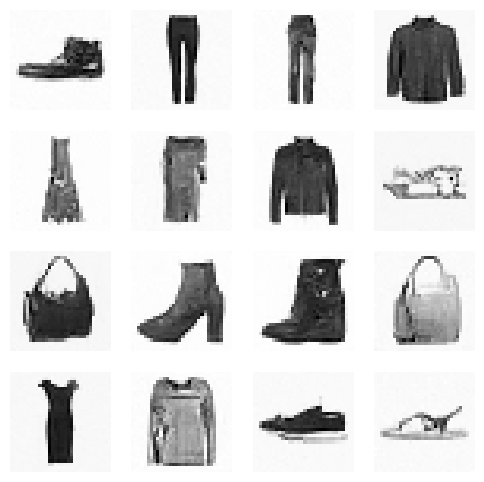

In [31]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

show_images(s[:16], imsize=1.5)